In [25]:
import json
import mirdata
import utilities 

class customTrack():
    """custom RobbieWilliams Track"""
    def __init__(self,basepath,track_id,title,album,chords,keys):
        self.track_id = track_id
        self.audio_path = f"{basepath}robbiewilliams/audio/{album}/{title}.mp3"
        self.chords_path = f"{basepath}robbiewilliams/annotations/chords/{album}/{chords}"
        self.keys_path = f"{basepath}robbiewilliams/annotations/keys/{album}/{keys}"

    def __repr__(self):
        return f"Track(\naudio_path={self.audio_path}\nchords_path={self.chords_path}\nkeys_path={self.keys_path}\n)"


basepath = "/home/max/ET-TI/Masterarbeit/mirdata/"
datasetname = "robbiewilliams"

queen = mirdata.initialize("queen",data_home=basepath+"queen")#
data = queen.load_tracks()


# Robbie Williams loader
tracks = {}
with open(basepath+datasetname+'/index.json') as json_file:
    data = json.load(json_file)
    for track in data["tracks"]:
        tracks[track["track_id"]] = customTrack(basepath,track["track_id"],track["title"],track["album"],track["chords"],track["keys"])


{'0': Track(
  audio_path="/home/max/ET-TI/Masterarbeit/mirdata/queen/audio/Greatest Hits I/01 Bohemian Rhapsody.flac",
  chords_path="...ET-TI/Masterarbeit/mirdata/queen/annotations/chordlab/Queen/Greatest Hits I/01 Bohemian Rhapsody.lab",
  keys_path="...x/ET-TI/Masterarbeit/mirdata/queen/annotations/keylab/Queen/Greatest Hits I/01 Bohemian Rhapsody.lab",
  sections_path="...x/ET-TI/Masterarbeit/mirdata/queen/annotations/seglab/Queen/Greatest Hits I/01 Bohemian Rhapsody.lab",
  title="01 Bohemian Rhapsody",
  track_id="0",
  audio: The track's audio

        Returns,
  chords: ,
  key: ,
  sections: ,
), '1': Track(
  audio_path="/home/max/ET-TI/Masterarbeit/mirdata/queen/audio/Greatest Hits I/02 Another One Bites The Dust.flac",
  chords_path="...terarbeit/mirdata/queen/annotations/chordlab/Queen/Greatest Hits I/02 Another One Bites The Dust.lab",
  keys_path="...asterarbeit/mirdata/queen/annotations/keylab/Queen/Greatest Hits I/02 Another One Bites The Dust.lab",
  sections_path=".

frames per beat: 4.0


(0.0, 10.0)

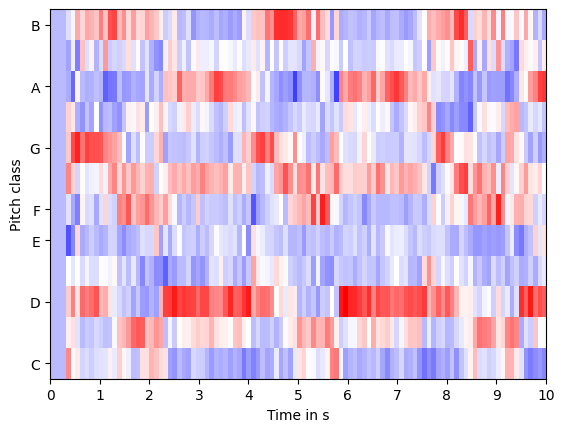

In [23]:
import numpy as np
import utilities
import features
import matplotlib.pyplot as plt
path = "/home/max/ET-TI/Masterarbeit/mirdata/beatles/audio/01_-_Please_Please_Me/09_-_P._S._I_Love_You.wav"
t,sig = utilities.loadAudio(path,t_stop=30)
t_chroma,chroma = features.crpChroma(sig)
beats,tempo_bpm = features.beats(sig)
fpb = 60 // ((t_chroma[1]-t_chroma[0])*tempo_bpm)
print(f"frames per beat: {fpb}")
 
fig,ax = plt.subplots()
utilities.plotChromagram(ax,t_chroma,chroma)
ax.set_xlim(0,10)

self transition probability: 0.875
self transition probability: 0.8333333333333334
self transition probability: 0.8
self transition probability: 0.6666666666666667


Recurrency plots


TypeError: plotChromagram() got an unexpected keyword argument 'vmin'

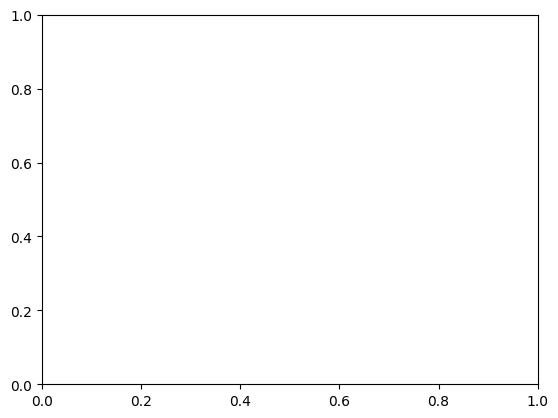

In [29]:
# load dataset
import dataloader
import utilities
import transcribe
import matplotlib.pyplot as plt
import numpy as np
import madmom
import os
from datetime import datetime
import features
import pickle

path = "/home/max/ET-TI/Masterarbeit/mirdata/beatles/audio/01_-_Please_Please_Me/09_-_P._S._I_Love_You.wav"
try:
    t,sig = utilities.loadAudio(path,t_stop=30)
    t_chroma, chroma = features.crpChroma(sig,nCRP=25,norm="l2")
except Exception as e:
    print(e)
    t_chroma, chroma = features.crpChroma(sig,nCRP=55,norm="l2")

fig,ax = plt.subplots()
img = utilities.plotChromagram(ax,t_chroma,chroma,vmin=-np.max(chroma),vmax=np.max(chroma),cmap="bwr")
plt.colorbar(img,ax=ax)
chord_processor = madmom.features.chords.DeepChromaChordRecognitionProcessor()
estimations = chord_processor(chroma.T)
intervals = np.array([(x[0],x[1]) for x in estimations])
labels = [x[2] for x in estimations]
print(intervals,labels)

(0.0, 10.0)

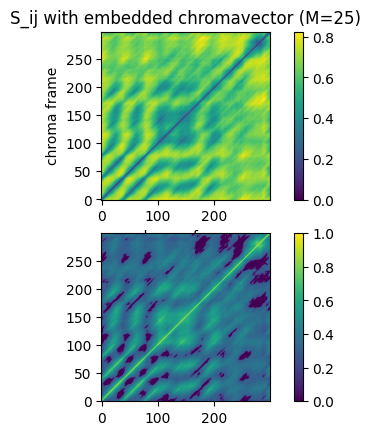

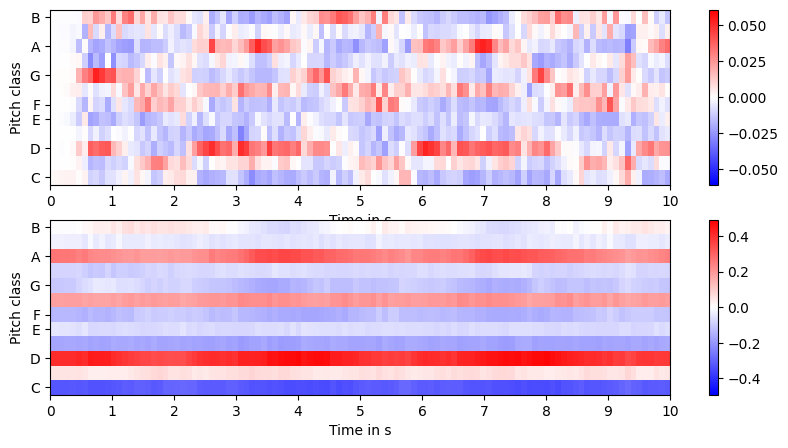

In [185]:

# Self similarity matrix with embedded chroma-vector 
N = t_chroma.shape[0]
M = 25
S = np.zeros((N-M+1,N-M+1),dtype=float)


for i in range(N-M+1):
    c_1 = chroma[:,i:i+M].flatten() 
    c_1_norm = c_1 / np.linalg.norm(c_1)
    for col_index in range(N-M+1):
        # compute normalized embedded chromavector
        c_2 = chroma[:,col_index:col_index+M].flatten() 
        c_2_norm = c_2 / np.linalg.norm(c_2)
        c_diff = (c_2_norm - c_1_norm)
        S[i,col_index] = np.linalg.norm(c_diff) / 2

fig,ax = plt.subplots(2,1)
img = ax[0].imshow(S,origin='lower')
plt.colorbar(img,ax=ax[0])
ax[0].set_xlabel("chroma frame")
ax[0].set_ylabel("chroma frame")
ax[0].set_title(f"S_ij with embedded chromavector (M={M})")

Theta = 50
threshold = np.zeros_like(t_chroma,dtype=float)
R = np.zeros_like(S)
for j in range(N-M+1):
    s = S[:,j]
    s = np.sort(s)[::-1]  # sort in ascending order
    threshold[j] = s[Theta]
for i in range(N-M+1):
    for j in range(N-M+1):
        x = S[i,j]
        if x <= threshold[i] or x <= threshold[j]:
            R[i,j] = 1
W = (1-S) * R
img = ax[1].imshow(W,origin='lower')
plt.colorbar(img,ax=ax[1])
chroma_smoothed = np.copy(chroma)

for n in range(N-M+1):
    for m in range(M):
        temp = np.zeros((12,),dtype=float)
        if n-m > 0:
            column = n-m
        else:
            column = 0
        for i in range(N-M+1):
            temp += W[i,column]*chroma[:,i]
        chroma_smoothed[:,n] += temp / np.sum(W[:,column])

fig,ax = plt.subplots(2,1,figsize=(10,5))
img = utilities.plotChromagram(ax[0],t_chroma,chroma,vmin=-np.max(chroma),vmax=np.max(chroma),cmap="bwr")
plt.colorbar(img,ax=ax[0])
ax[0].set_xlim(0,10)
img = utilities.plotChromagram(ax[1],t_chroma,chroma_smoothed,vmax=np.max(chroma_smoothed),vmin=-np.max(chroma_smoothed),cmap="bwr")
plt.colorbar(img,ax=ax[1])
ax[1].set_xlim(0,10)

$C(c,n) = \sum_{m=0}^{M-1} \frac{\sum_{i=1}^{\hat{N}}W_{i,n-m}\: C(c,i)}{\sum_{i=1}^{\hat{N}}W_{i,n-m}} \hspace{1cm} \hat{N} = N-M+1$

In [4]:
# load dataset
import dataloader
import utilities
import transcribe
import matplotlib.pyplot as plt
import numpy as np
import madmom
import os
from datetime import datetime
import features
import pickle

parameters = {"chroma_type":"crp",
        "vocabulary":"majmin_sevenths",  # triads, triads_extended, majmin_sevenths
        "eval_scheme":"majmin_sevenths",
        "hprs":False,
        "prefilter":"median",
        "prefilter_length":17,
        "postfilter":"hmm",
        "transition_prob":0.2,
        "save_transcription":False
}

PATH = "/home/max/ET-TI/Masterarbeit/mirdata/"
output_path = "/home/max/ET-TI/Masterarbeit/results/"
timestamp = datetime.now().strftime('%m_%d_%Y_%H_%M_%S')
output_path += timestamp
os.mkdir(output_path)
if parameters.get('save_transcription',False):
    os.mkdir(output_path+"/chromagrams")
    os.mkdir(output_path+"/transcriptions")
results= {}
results["parameters"] = parameters
for fold in range(1,9):
    for name in ["rwc_popular","beatles"]:
        dataset = dataloader.MIRDataset(name,basepath=PATH,split_nr=fold)
        for track_id in dataset.getTrackList():
            try:
                name = dataset.getTitle(track_id).split("_-_")[-1]
                track_results = {}
            except KeyError:
                print(f"error loading {name}.. skipping song")
                continue
            audiopath,(ref_intervals,ref_labels) = dataset[track_id]

            time_vector,signal = utilities.loadAudio(audiopath)

            ## HPS ##
            if parameters.get("hprs",False):
                y_harm,y_perc,y_res = transcribe.harmonicPercussiveResidualSeparation(signal,beta=3,n_fft=4096)
                signal = madmom.audio.signal.Signal(y_harm, sample_rate=signal.sample_rate, num_channels=1, start=signal.start, stop=signal.stop)

            if parameters.get("chroma_type","crp") == "crp":
                t_chroma,chroma = features.crpChroma(signal)
            elif parameters.get("chroma_type") == "dcp":
                t_chroma,chroma = features.deepChroma(signal,split_nr=fold)
            else:
                t_chroma,chroma = features.cqtChroma(signal)

            est_intervals, est_labels = transcribe.transcribeChromagram(t_chroma,chroma,**parameters)
            score,mean_seg_score = transcribe.evaluateTranscription(est_intervals,est_labels,ref_intervals,ref_labels,parameters.get("eval_scheme","majmin"))
            print(f"Track: {name}, {parameters.get('eval_scheme','majmin')}: {round(score*100,1)}, segmentation: {round(mean_seg_score*100,1)}")
            track_results[parameters.get('eval_scheme','majmin')] = score
            track_results["segmentation"] = mean_seg_score
            if parameters.get('save_transcription',False):
                track_results["t_chroma"] = t_chroma
                track_results["chroma"] = chroma
                track_results["est_intervals"] = est_intervals
                track_results["est_labels"] = est_labels
                utilities.saveTranscriptionResults(output_path,name,t_chroma,chroma,est_intervals,est_labels,ref_intervals,ref_labels)

            results[name] = track_results 
            break
        continue
f = open(output_path+f"/{parameters.get('eval_scheme','majmin')}_{parameters.get('chroma_type')}.pkl","wb")
pickle.dump(results, f)
f.close()


Track: Magic in your eyes, majmin_sevenths: 6.0, segmentation: 32.0
Track: Do_You_Want_To_Know_A_Secret, majmin_sevenths: 37.0, segmentation: 68.0
Track: Catch ball, majmin_sevenths: 54.0, segmentation: 85.0
Track: Misery, majmin_sevenths: 65.0, segmentation: 84.0
Track: HORO, majmin_sevenths: 49.0, segmentation: 76.0
Track: I_Saw_Her_Standing_There, majmin_sevenths: 75.0, segmentation: 79.0
Track: old fashioned, majmin_sevenths: 57.0, segmentation: 81.0
Track: Anna_(Go_To_Him), majmin_sevenths: 9.0, segmentation: 67.0
Track: KAGE-ROU, majmin_sevenths: 58.0, segmentation: 83.0
Track: There's_A_Place, majmin_sevenths: 79.0, segmentation: 87.0
Track: Eien no replica, majmin_sevenths: 39.0, segmentation: 80.0
Track: Love_Me_Do, majmin_sevenths: 53.0, segmentation: 25.0
Track: Funky Life, majmin_sevenths: 8.0, segmentation: 68.0
Track: Ask_Me_Why, majmin_sevenths: 42.0, segmentation: 75.0
Track: Doukoku, majmin_sevenths: 68.0, segmentation: 82.0
Track: Boys, majmin_sevenths: 20.0, segmenta

In [6]:
file = open("/home/max/ET-TI/Masterarbeit/results/11_03_2023_16_22_58/majmin_sevenths_crp.pkl", 'rb')
data = pickle.load(file) 
print(data)
for key in data:
    print(key)

{'parameters': {'chroma_type': 'crp', 'vocabulary': 'majmin_sevenths', 'eval_scheme': 'majmin_sevenths', 'hprs': False, 'prefilter': 'median', 'prefilter_length': 17, 'postfilter': 'hmm', 'transition_prob': 0.2, 'save_transcription': False}, 'Magic in your eyes': {'majmin_sevenths': 0.06, 'segmentation': 0.32}, 'Do_You_Want_To_Know_A_Secret': {'majmin_sevenths': 0.37, 'segmentation': 0.68}, 'Catch ball': {'majmin_sevenths': 0.54, 'segmentation': 0.85}, 'Misery': {'majmin_sevenths': 0.65, 'segmentation': 0.84}, 'HORO': {'majmin_sevenths': 0.49, 'segmentation': 0.76}, 'I_Saw_Her_Standing_There': {'majmin_sevenths': 0.75, 'segmentation': 0.79}, 'old fashioned': {'majmin_sevenths': 0.57, 'segmentation': 0.81}, 'Anna_(Go_To_Him)': {'majmin_sevenths': 0.09, 'segmentation': 0.67}, 'KAGE-ROU': {'majmin_sevenths': 0.58, 'segmentation': 0.83}, "There's_A_Place": {'majmin_sevenths': 0.79, 'segmentation': 0.87}, 'Eien no replica': {'majmin_sevenths': 0.39, 'segmentation': 0.8}, 'Love_Me_Do': {'maj

(25, 108)
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


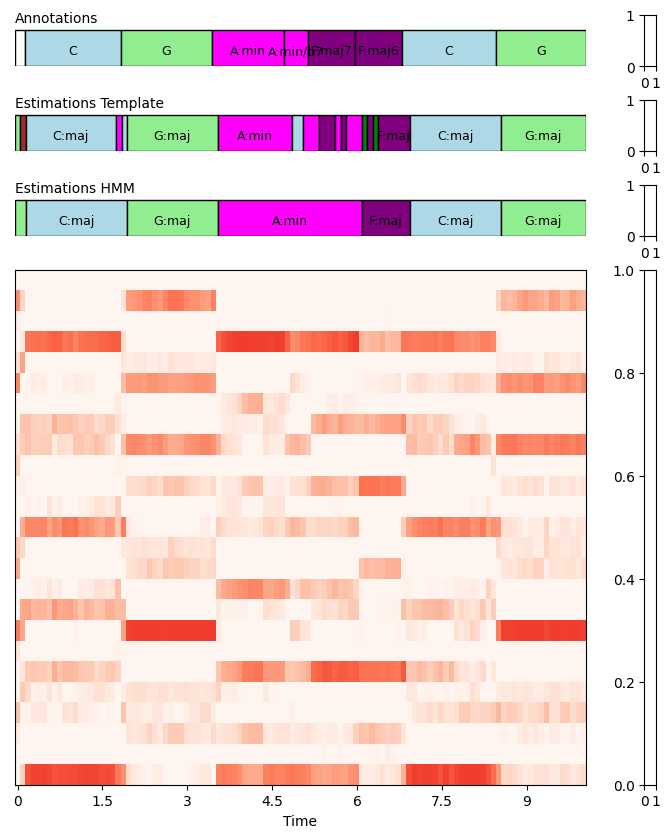

In [15]:
import dataloader
import madmom
import utilities
import features
import transcribe
import librosa
import matplotlib.pyplot as plt
import numpy as np

model_path = [f"/home/max/ET-TI/Masterarbeit/models/ismir2016/chroma_dnn_3.pkl"]
dcp = madmom.audio.chroma.DeepChromaProcessor(fmin=30, fmax=5500, unique_filters=False,models=model_path)
dataset = dataloader.MIRDataset("beatles",basepath="/home/max/ET-TI/Masterarbeit/mirdata/",split_nr=3)

featureprocessor = madmom.features.CNNChordFeatureProcessor()
decoder = madmom.features.CRFChordRecognitionProcessor()

audiopath,gt = dataset["1206"]
# audiopath = audiopath.rsplit('.', 1)[0] + '.mp3'  # for rwc datasets
timevector,sig = utilities.loadAudio(audiopath,t_stop=10)
t_chroma, chroma = features.crpChroma(sig,nCRP=55)
correlation,labels = transcribe.computeTemplateCorrelation(chroma,template_type="majmin")
est_labels = [labels[np.argmax(correlation[:,i])] for i in range(chroma.shape[1])]

est_intervals,est_labels =  utilities.createChordIntervals(t_chroma,est_labels)
correlation,labels = transcribe.computeTemplateCorrelation(chroma,"majmin")
# neglect negative values of the correlation
correlation = np.clip(correlation,0,100)
A = transcribe.uniform_transition_matrix(0.06,len(labels))
B_O = correlation / np.expand_dims(np.sum(correlation,axis=0),axis=0)
C = np.ones((len(labels,))) * 1/len(labels)   # uniform initial state probability -> or start with "N"? 
chord_HMM, _, _, _ = transcribe.viterbi_log_likelihood(A, C, B_O)
seq = np.argmax(chord_HMM,axis=0)
labels_HMM = [labels[i] for i in seq]
est_intervals_hmm, est_labels_hmm = utilities.createChordIntervals(t_chroma,labels_HMM)   

# est_intervals_hmm, est_labels_hmm = transcribe.transcribeHMM(t_chroma,chroma,p=0.9,template_type="majmin")
fig,ax = plt.subplots(4,2,height_ratios=(1,1,1,10),width_ratios=(50,1),figsize=(8.27,10))
utilities.plotChordAnnotations(ax[0,0],gt,(0,10))
ax[0,0].text(0,1.7,"Annotations")
utilities.plotChordAnnotations(ax[1,0],(est_intervals,est_labels),(0,10))
ax[1,0].text(0,1.7,"Estimations Template")
utilities.plotChordAnnotations(ax[2,0],(est_intervals_hmm,est_labels_hmm),(0,10))
ax[2,0].text(0,1.7,"Estimations HMM")
img = librosa.display.specshow(correlation,x_coords=t_chroma.T,x_axis='time', vmin=0,vmax=np.max(chroma),cmap='Reds', ax=ax[3,0])


Text(0, 0.5, 'Amplitude')

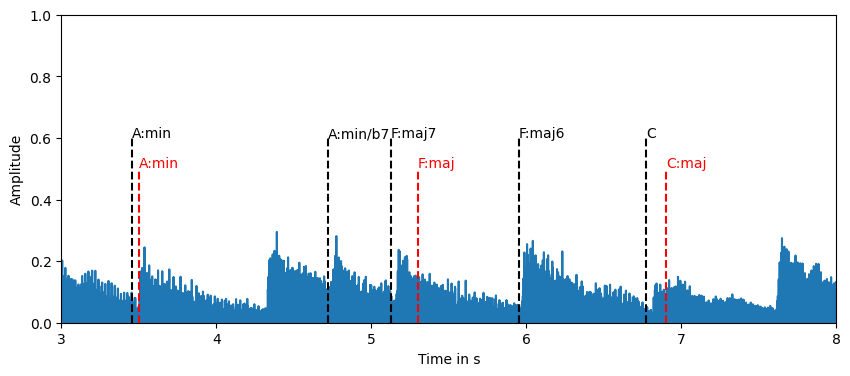

In [39]:
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(timevector,sig)
ax.set_ylim(0,1)
ax.set_xlim(3,8)
for t,x in zip(est_intervals,est_labels):
    if t[0] < 3:
        continue
    elif t[0] > 8:
        break
    ax.vlines(t[0],0,0.5,'r',linestyles='dashed')
    ax.text(t[0],.505,x,color='r')
for t,x in zip(gt[0],gt[1]):
    if t[0] < 3:
        continue
    elif t[0] > 8:
        break

    ax.vlines(t[0],0,0.6,'k',linestyles="dashed")
    ax.text(t[0],0.601,x,color='k')

ax.set_xlabel("Time in s")
ax.set_ylabel("Amplitude")

(0.87, 0.77)


(0.0, 20.0)

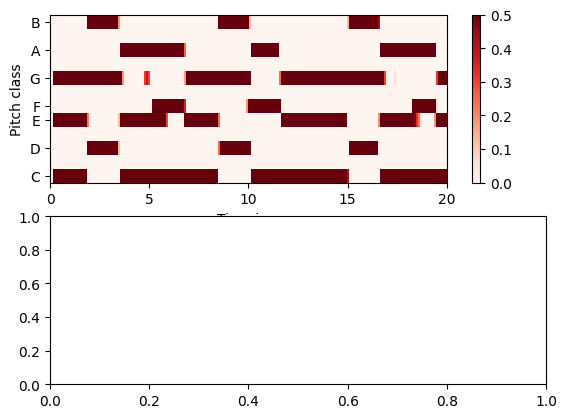

In [15]:
import evaluate

est_intervals = np.array([(x[0],x[1]) for x in chords])
est_labels = [x[2] for x in chords]

print(evaluate.evaluateTranscription(est_intervals,est_labels,gt[0],gt[1]))
t = np.linspace(timevector[0],timevector[-1],chroma.shape[0])
fig,ax = plt.subplots(2,1)
img = utilities.plotChromagram(ax[0],t,chroma)
fig.colorbar(img)
ax[0].set_xlim(0,20)

In [1]:
import madmom
import matplotlib.pyplot as plt
import utilities 
import features
import numpy as np
import mir_eval
import pitchspace
import librosa
import itertools
from scipy.signal import find_peaks

Zeitrasterung/processingrate der Features
-> fein abgetastete Beatactivations als feature für die zeitliche Akkordanalyse verwenden
gewichtung anhand von beataktivierung

(20.0, 30.0)

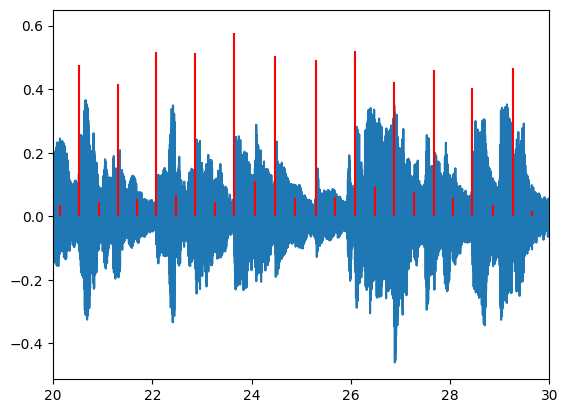

In [74]:
t_start = 0
t_stop = 40
path = "/home/max/ET-TI/Masterarbeit/mirdata/beatles/"
titles = ["06_-_Rubber_Soul/11_-_In_My_Life", "12_-_Let_It_Be/06_-_Let_It_Be","10CD1_-_The_Beatles/CD1_-_17_-_Julia"]
title = "06_-_Rubber_Soul/11_-_In_My_Life"
# title = "08_-_Sgt._Pepper's_Lonely_Hearts_Club_Band/01_-_Sgt._Pepper's_Lonely_Hearts_Club_Band"
title = "12_-_Let_It_Be/06_-_Let_It_Be"
# title = "10CD1_-_The_Beatles/CD1_-_17_-_Julia"
audiopath = f"{path}/audio/{title}.wav"

timevector,sig = utilities.loadAudio(audiopath,t_start,t_stop)

activation_processor =  madmom.features.beats.RNNBeatProcessor() 
activations = activation_processor(sig)

# estimate the smallest beat in the signal (lag at first maximum of activation autocorrelation)
act_xx = np.correlate(activations, activations, mode='full')[activations.shape[0]-1:]
act_xx = act_xx / np.max(act_xx)
peaks,_ = find_peaks(act_xx,prominence=0.01)
peaks,peak_params = find_peaks(activations,height=0.001,prominence=0.001,distance=peaks[0]//2)
beats = [p/100 for p in peaks]    # seconds
beat_activations = [activations[b] for b in peaks]
fig,ax = plt.subplots()
ax.plot(timevector,sig)
ax.vlines(beats,0,beat_activations,'r')
ax.set_xlim(20,30)

(0.0, 10.0)

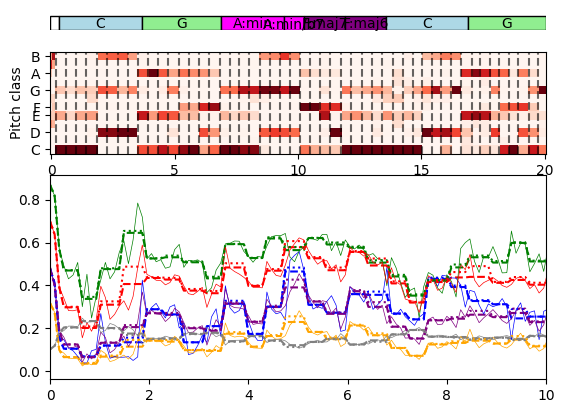

In [6]:

beats = features.beats(sig)
t,chroma = features.crpChroma(sig,nCRP=22,filter_scale=1)

chroma_smoothed = utilities.smoothChromagram(t,chroma,beats)
target = mir_eval.io.load_labeled_intervals(path+"/annotations/chordlab/The Beatles/"+title+".lab",' ','#')

f0, voiced_flag, voiced_probs = librosa.pyin(np.array(sig.data),
                                             fmin=librosa.note_to_hz('C2'),
                                             fmax=librosa.note_to_hz('C4'))
librosa.hz_to_note(440.0 * (2.0 ** np.linspace(0, 1, 12)),
                   octave=False)
bass_chroma = np.zeros((f0.shape[0],12))
for i,freq in enumerate(f0):
    try:
        x = librosa.hz_to_note(freq,octave=False,unicode=False)
        root,_,_ = mir_eval.chord.encode(x)
        bass_chroma[i,root] = 1
    except ValueError:
        continue
        
# COMPLEXITY
colors = ["blue", "green", "red", "orange", "purple", "grey"]
complexity_features = [
                features.sumChromaDifferences(chroma),
                features.angularDeviation(chroma),
                features.shannonEntropy(chroma),
                features.negativeSlope(chroma),
                features.nonSparseness(chroma),
                features.standardDeviation(chroma)
]
complexity_features_smooth = [
                features.sumChromaDifferences(chroma_smoothed),
                features.angularDeviation(chroma_smoothed),
                features.shannonEntropy(chroma_smoothed),
                features.negativeSlope(chroma_smoothed),
                features.nonSparseness(chroma_smoothed),
                features.standardDeviation(chroma_smoothed)
]

fig,ax = plt.subplots(3,1,height_ratios=(1,5,10))
utilities.plotChordAnnotations(ax[0],target,(t_start,t_stop))
utilities.plotChromagram(ax[1],t,chroma_smoothed,beats)
for i,x in enumerate(complexity_features):    
    complexity_mean = np.copy(x)
    for b0,b1 in itertools.pairwise(beats):
        # median filter
        try:
            idx0 = np.argwhere(t >= b0)[0][0]
        except IndexError:
            # no matching interval found at array boundaries
            idx1 = 0
        try:
            idx1 = np.argwhere(t >= b1)[0][0]
        except IndexError:
            idx1 = t.shape[0] 
        if idx1-idx0 > 0: 
            complexity_mean[idx0:idx1] = np.mean(x[idx0:idx1])
    ax[2].plot(t,complexity_mean,color=colors[i],linestyle='--')

for i,x in enumerate(complexity_features):    
    ax[2].plot(t,x,color=colors[i],linewidth=0.5)
for i,x in enumerate(complexity_features_smooth):
    ax[2].plot(t,x,color=colors[i],linestyle=':')
ax[2].set_xlim([t_start,t_stop])
